# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [176]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
from sklearn import linear_model
import datetime as dt

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

#Integracia
from scipy.stats import boxcox
import scipy.stats as stats

# Func Defintions

In [177]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [178]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    # Pomenujeme si index
    data.index.name = 'ID'
    # Ujednoti format nazvov stlpcov
    data = data.rename(columns=fixWierdCharsInString)
    print("Index name", data.index.name)
    print(data.columns)
    return data

In [179]:
def create_csv(df, file_name):
    df.to_csv(file_name, sep='\t')

In [180]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(data.name, z, pval, True if pval > 0.05 else False)
    if(pval > 0.05):
        return True
    return False

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [181]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [182]:
def checkAllNumericType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    numeric_data = data.select_dtypes(['int64','float64'])
    for col_name in numeric_data.columns:
        #Spočítame si pre každý "Numerický" atribút počet jeho jedinečných hodnôt
        print(col_name,": modus:",numeric_data[col_name].mode(),", mean:", numeric_data[col_name].describe())
    numeric_data.apply(isNormalDistribution)

In [183]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                #print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                #print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            #print(string)
            return pd.NaT

In [184]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    return forloop

In [185]:
def calculateAgeFromDate(data, start_date):
    date = pd.to_datetime(start_date)
    data.loc[data[age_column].isna() & data[date_column].notna(), age_column] = (date - data.loc[(data[age_column].isna() & data[date_column].notna()), date_column]).astype('int64') 

# Dataset

In [186]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/test.csv"
test_data = init_dataset(test_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [187]:
train_file = "data/zadanie4/train.csv"
train_data = init_dataset(train_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [188]:
#Aby sme mohli pracovat 
#data = train_data
data = train_data

# Zjednotenie formátov a typov dát

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 39 columns):
AGE                          2799 non-null float64
SEX                          2800 non-null object
ON_THYROXINE                 2800 non-null object
QUERY_ON_THYROXINE           2800 non-null object
ON_ANTITHYROID_MEDICATION    2800 non-null object
SICK                         2800 non-null object
PREGNANT                     2800 non-null object
THYROID_SURGERY              2800 non-null object
I131_TREATMENT               2800 non-null object
QUERY_HYPOTHYROID            2800 non-null object
QUERY_HYPERTHYROID           2800 non-null object
LITHIUM                      2800 non-null object
GOITRE                       2800 non-null object
TUMOR                        2800 non-null object
HYPOPITUITARY                2800 non-null object
PSYCH                        2800 non-null object
TSH_MEASURED                 2800 non-null object
TSH                          2516 non-null

In [190]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 2
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 210
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [191]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    2505.000000
mean      110.787984
std        32.883986
min         2.000000
25%        93.000000
50%       107.000000
75%       124.000000
max       395.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 

In [192]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')

data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], ['female', 'male'], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

female    1830
male       860
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [193]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)

In [194]:
checkAllObjectType(data)

SEX : 2
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


In [195]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [196]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     904
HUSBAND           550
UNMARRIED         510
OWN_CHILD         494
WIFE              253
OTHER_RELATIVE     89
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [197]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

count                    2519
unique                   2394
top       1957-08-19 00:00:00
freq                        3
first     1923-05-30 00:00:00
last      2016-11-03 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [198]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Other-service,United-States,Widowed,private,Black
1,Adm-clerical,United-States,Separated,Local-gov,White
2,Sales,United-States,Married-civ-spouse,private,White
3,Sales,United-States,Never-married,Private,Black
4,Adm-clerical,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [199]:
checkAllObjectType(df_personal_data)

JOB : 14
STATE : 37
MARITAL_STATUS : 7
JOB_SEGMENT : 15
RACE : 5


In [200]:
fixWierdCharsInObjectType(df_personal_data)

{'JOB': {'ADM_CLERICAL': 0.1654482493266641,
  'CRAFT_REPAIR': 0.07772220084647942,
  'EXEC_MANAGERIAL': 0.13659099653712967,
  'FARMING_FISHING': 0.021546748749519045,
  'HANDLERS_CLEANERS': 0.02308580223162755,
  'MACHINE_OP_INSPCT': 0.06156213928434013,
  'OTHER_SERVICE': 0.15390534821085033,
  'PRIV_HOUSE_SERV': 0.011158137745286649,
  'PROF_SPECIALTY': 0.14697960754136205,
  'PROTECTIVE_SERV': 0.019622931896883418,
  'SALES': 0.12158522508657175,
  'TECH_SUPPORT': 0.032320123124278566,
  'TRANSPORT_MOVING': 0.02847248941900731},
 'JOB_SEGMENT': {'?': 0.07107142857142858,
  'FEDERAL_GOV': 0.029285714285714286,
  'LOCAL_GOV': 0.07785714285714286,
  'NEVER_WORKED': 0.0007142857142857143,
  'PRIVATE': 0.6982142857142857,
  'SELF_EMP_INC': 0.024642857142857143,
  'SELF_EMP_NOT_INC': 0.055,
  'STATE_GOV': 0.04285714285714286,
  'WITHOUT_PAY': 0.00035714285714285714},
 'MARITAL_STATUS': {'DIVORCED': 0.18535714285714286,
  'MARRIED_AF_SPOUSE': 0.00035714285714285714,
  'MARRIED_CIV_SPOUSE

In [201]:
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK
1,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE
2,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE
3,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK
4,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [202]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [203]:
column = fixWierdCharsInString('class')
data[column].head()

ID
0    replacement therapy.|3560
1                negative.|311
2               negative.|3705
3               negative.|2668
4    replacement therapy.|1668
Name: CLASS, dtype: object

In [204]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [205]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [206]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     894
10.0    670
13.0    437
14.0    138
11.0    130
12.0    103
7.0      97
6.0      79
8.0      54
4.0      45
15.0     42
5.0      41
16.0     25
3.0      24
2.0      17
1.0       4
Name: EDUCATION_NUM, dtype: int64

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [207]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [208]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [209]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


,SEX,REFERRAL_SOURCE,EDUCATION,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,
0,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK,REPLACEMENT_THERAPY
1,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE,NEGATIVE
2,MALE,OTHER,HS_GRAD,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
3,FEMALE,OTHER,SOME_COLLEGE,OWN_CHILD,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
4,FEMALE,OTHER,ASSOC_VOC,OWN_CHILD,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,REPLACEMENT_THERAPY


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Normalizácia dát

In [210]:
numeric_data = data.select_dtypes(include=['float', 'int'])

In [211]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
#numeric_data.dropna().apply(isNormalDistribution)
pd.DataFrame(s).apply(isNormalDistribution)

0 0.9254994399593743 0.6295501766232616 True


0    True
dtype: bool

In [212]:
measures = data.loc[:, ['TSH', 'T4U', 'T3', 'TT4', 'FTI']]
measures.head()

,TSH,T4U,T3,TT4,FTI
ID,,,,,
0,2.90,NaN,1.2,174.0,NaN
1,0.20,0.97,NaN,105.0,108.0
2,2.10,NaN,1.7,96.0,NaN
3,0.02,1.10,3.4,91.0,83.0
4,0.69,0.99,NaN,162.0,163.0


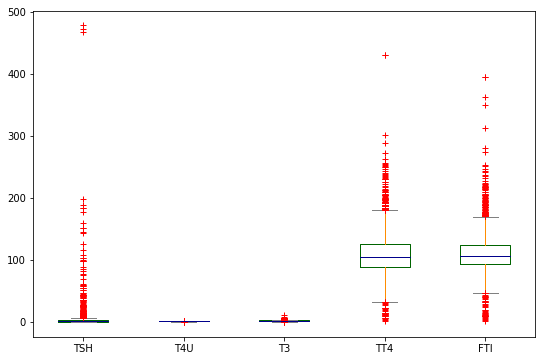

In [213]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
measures.plot.box(color=color, sym='r+', positions=[3, 4, 5, 6, 7])

In [214]:
# sklearn.preprocessing
#measures.fillna(0, inplace=True)
measures.dropna(inplace=True)
tmp = pd.DataFrame(preprocessing.scale(measures))
#tmp = pd.DataFrame()
#for column in measures:
 #   tmp[column] = preprocessing.scale(measures[column], axis=0)

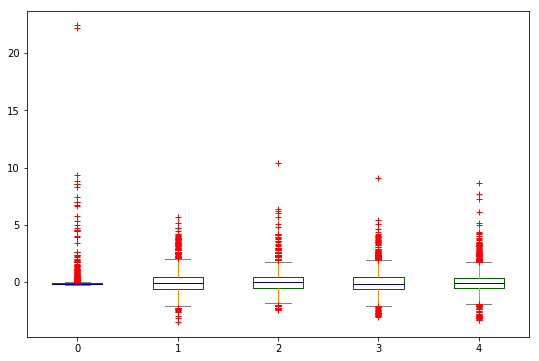

In [215]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
pd.DataFrame(tmp).plot.box(color=color, sym='r+')

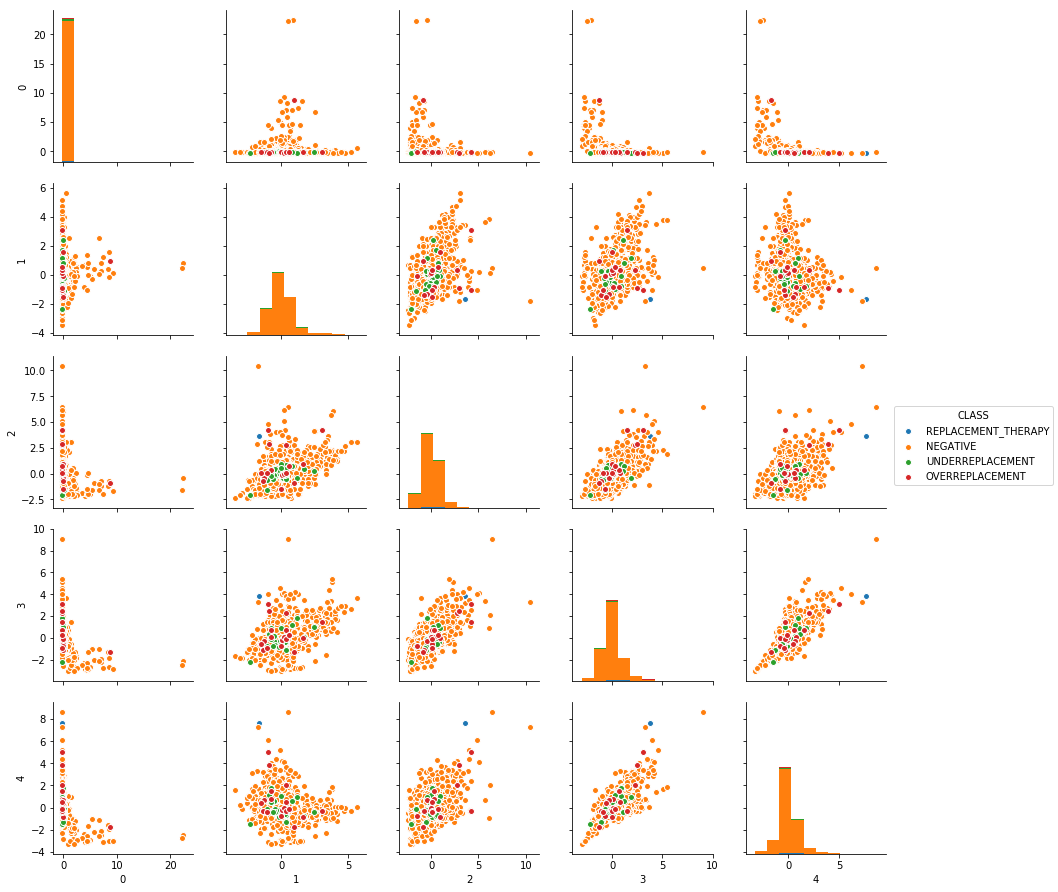

In [216]:
column1_name = 'CLASS'

tmp[column1_name] = data[column1_name]

seaborn.pairplot(tmp, dropna=True, hue=column1_name)

In [217]:
numeric_data.apply(count_missing)

NameError: name 'count_missing' is not defined

In [ ]:
numeric_data['FTI'].plot.hist()

In [ ]:
# z-normalization: shift = mean, scale = std
# 0-1 normalization: shift = min, scale =  max - min
# toto iste robi StandardScaler pre vsetky atributy. Pozor ale na power law
# ak pouzijete RobustScaler, tak si viete poradit aj s outliermi (pouziva rozsah 1st quartile (25th quantile) and the 3rd quartile (75th quantile))
def normalization(data, shift, scale): 
    return (np.array(data) - float(shift))/scale

In [ ]:
numeric_data.plot.hist(alpha=0.1)

In [218]:
data['TSH'].isna().sum()

284

Text(0.5,1,'index: %d (without box-cox)')

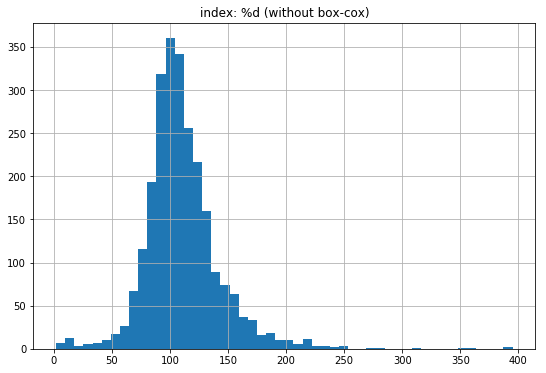

In [219]:

transformed = data['FTI'].dropna()# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (without box-cox)")

Text(0.5,1,'index: 20 (box-cox)')

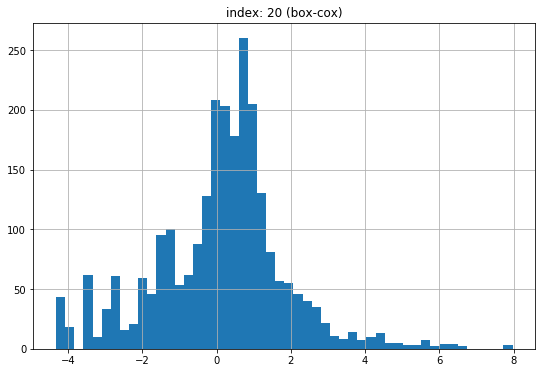

In [220]:
index = 20
transformed, att = boxcox(data['TSH'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (box-cox)" % index)

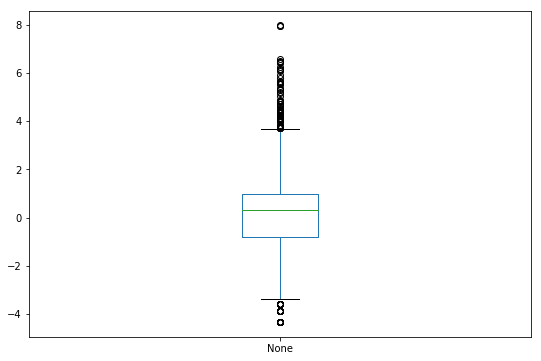

In [221]:
pd.Series(transformed).plot(kind='box')

In [222]:
z_transformed = normalization(transformed, np.mean(transformed), np.std(transformed))
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

NameError: name 'normalization' is not defined

In [223]:
# sklearn.preprocessing
preprocessing.scale(transformed)
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

NameError: name 'z_transformed' is not defined

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

Atribút **age** odstránenie odchýlených hodnôt.

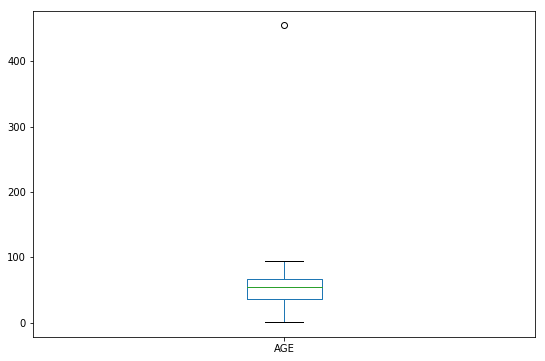

In [224]:
data['AGE'].plot(kind="box")

In [225]:
column = fixWierdCharsInString('age')
data[(data[column] < 1) | (data[column] > 100)]

,AGE,SEX,ON_THYROXINE,QUERY_ON_THYROXINE,ON_ANTITHYROID_MEDICATION,SICK,PREGNANT,THYROID_SURGERY,I131_TREATMENT,QUERY_HYPOTHYROID,...,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,DATE_OF_BIRTH,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,,,,,,,,,,,,
685,455.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,40,NaT,SALES,UNITED_STATES,DIVORCED,PRIVATE,WHITE,NEGATIVE


Táto vychýlená hodnota vznikla pravdepodobne nesprávne odmeranými alebo vyplnenými údajmi. Skutočný vek tohto pacienta mohol byť napríklad 45 rokov, ale aj 55 rokov, no nevieme to zistiť tak sa rozhodneme tohto pacienta odstrániť. 

In [226]:
#data.drop(data[data.AGE > 100].index) - nefunguje (neviem prečo)
data = data[data.AGE < 100] # funguje

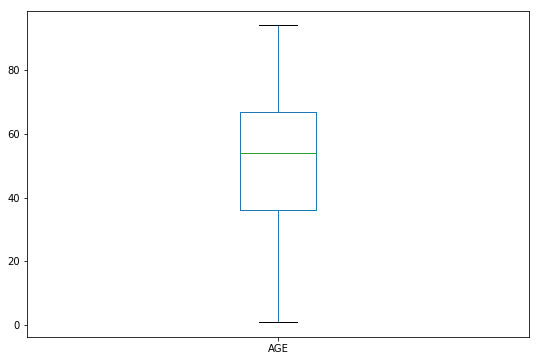

In [228]:
data['AGE'].plot(kind="box")

Ako iný spôsob odstránenia tejto vychýlenej hodnoty by sme mohli použiť nahradenie hornej vychýlenej hodnoty 95 percentilom a dolnej vychýlenej hodnoty 5 kvantilom. Takisto by sme mohli použiť aj metódu nahradenia medianom, pretože tento vek sa mohol pohybovať okolo 45, 55 rokov a to je približne median.

In [229]:
#data.loc[(data[column] > 100), column] = data[column].quantile(0.95) 
#data.loc[(data[column] < 1), column] = data[column].quantile(0.05)
data['AGE'].mode()

0    59.0
dtype: float64

# Chýbajúce hodnoty

Počty chýbajúcich hodnôt v jednotlivých atribútoch.
!!!http://scikit-learn.org/stable/data_transforms.html!!!

In [230]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [231]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [232]:
def prop_complete(data):
    return 1 - prop_missing(data)

In [234]:
data.apply(count_missing)

AGE                            0
SEX                          110
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                          284
T3_MEASURED                    0
T3                           585
TT4_MEASURED                   0
TT4                          184
T4U_MEASURED                   0
T4U                          297
FTI_MEASURED                   0
FTI                          295
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

In [235]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

0    1446
1     683
2     355
5     117
3     105
4      52
6      28
7       8
8       4
dtype: int64

In [236]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

(2798, 41)

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [237]:
data['SEX'].isna().sum()

110

In [238]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = 'FEMALE'
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [239]:
data['SEX'].isna().sum()

109

In [240]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = 'FEMALE'
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = 'MALE'
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))]
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))]

In [241]:
data['SEX'].isna().sum()

61

In [242]:
caluclateAgeOfDate(data,'2016-1-1')

NameError: name 'caluclateAgeOfDate' is not defined

## Doplnenie chýbajúcich hodnôt po stĺpcoch

### Vytvorenie inputerov

In [243]:
imp_most_frequent = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_median = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)

In [244]:
checkAllObjectType(data)

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 35
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [247]:
column = fixWierdCharsInString('capital_gain')
mode = data[column].mode()
data[column] = pd.DataFrame(imp_median.fit_transform(data.loc[:, [column]]))

In [248]:
data[column].isnull().sum()

2

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [249]:
column = fixWierdCharsInString('job')
data[column].isnull().sum()

201

In [250]:
general_value = fixWierdCharsInString('Other_service')
data[column].fillna(general_value, inplace=True)
data[column].isnull().sum()

0

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [251]:
column = fixWierdCharsInString('state')
data[column].isnull().sum()

43

In [252]:
mode = data[column].mode()
data[column].fillna(mode[0], inplace=True)

In [253]:
data[column].isnull().sum()

0

In [254]:
checkAllObjectType(data)

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 35
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


## TSH, T3, TT4, T4U, FTI

V týchto atribúte budeme doĺňať chýbajúce hodnoty pomocou stratégie modus (most_frequent) a lineárnej regresie. Tieto dve stratégie potom porovnáme. 

In [255]:
col_names = ['TSH', 'T4U', 'T3', 'TT4', 'FTI']

for col in col_names:
     data[col] = pd.DataFrame(imp_most_frequent.fit_transform(data.loc[:, [col]]))

### Metóda k najbližších susedov

In [256]:
from fancyimpute import KNN   
data['TSH'].isnull().sum()

2

In [257]:
X_filled_knn = pd.DataFrame(KNN(k=3).complete(data[col_names]))
X_filled_knn.rename(columns={0: 'TSH', 1: 'T4U', 2: 'T3', 3: 'TT4', 4: 'FTI'}, inplace=True)
X_filled_knn

Imputing row 1/2798 with 0 missing, elapsed time: 1.241
Imputing row 101/2798 with 0 missing, elapsed time: 1.242
Imputing row 201/2798 with 0 missing, elapsed time: 1.242
Imputing row 301/2798 with 0 missing, elapsed time: 1.242
Imputing row 401/2798 with 0 missing, elapsed time: 1.242
Imputing row 501/2798 with 0 missing, elapsed time: 1.243
Imputing row 601/2798 with 0 missing, elapsed time: 1.243
Imputing row 701/2798 with 0 missing, elapsed time: 1.243
Imputing row 801/2798 with 0 missing, elapsed time: 1.243
Imputing row 901/2798 with 0 missing, elapsed time: 1.244
Imputing row 1001/2798 with 0 missing, elapsed time: 1.244
Imputing row 1101/2798 with 0 missing, elapsed time: 1.244
Imputing row 1201/2798 with 0 missing, elapsed time: 1.244
Imputing row 1301/2798 with 0 missing, elapsed time: 1.245
Imputing row 1401/2798 with 0 missing, elapsed time: 1.245
Imputing row 1501/2798 with 0 missing, elapsed time: 1.246
Imputing row 1601/2798 with 0 missing, elapsed time: 1.246
Imputing 

,TSH,T4U,T3,TT4,FTI
0,2.90,0.99,1.2,174.0,100.0
1,0.20,0.97,2.0,105.0,108.0
2,2.10,0.99,1.7,96.0,100.0
3,0.02,1.10,3.4,91.0,83.0
4,0.69,0.99,2.0,162.0,163.0
5,3.00,1.13,1.1,122.0,108.0
6,1.10,0.95,2.2,115.0,121.0
7,26.00,0.80,0.3,6.0,7.6
8,0.25,0.95,1.9,165.0,174.0
9,0.05,0.66,1.1,108.0,165.0


In [258]:
for col in col_names:
    data[col] = X_filled_knn[col]

In [259]:
data['TSH'].isnull().sum()

2

In [263]:
data['JOB_SEGMENT'].value_counts()

PRIVATE             1953
LOCAL_GOV            218
SELF_EMP_NOT_INC     154
STATE_GOV            120
FEDERAL_GOV           82
SELF_EMP_INC          69
NEVER_WORKED           2
WITHOUT_PAY            1
Name: JOB_SEGMENT, dtype: int64

Chýbajúce hodnoty v atribúte **JOB_SEGMENT** sme doplnili pomocou najčastejšie sa vyskytujúcej hodnoty.

In [265]:
column = fixWierdCharsInString('job_segment')
mode = data[column].mode()
data[column].fillna(mode[0], inplace=True)

In [266]:
data.apply(count_missing)

AGE                            0
SEX                           61
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                            2
T3_MEASURED                    0
T3                             2
TT4_MEASURED                   0
TT4                            2
T4U_MEASURED                   0
T4U                            2
FTI_MEASURED                   0
FTI                            2
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [327]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

,B,C,A
0,1.341664,-1.337117,0
1,1.317796,-1.614323,1
2,0.052734,-0.630383,2
3,0.409249,-0.788780,3
4,-1.093194,-0.758686,4


In [328]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


,A,B,C,D
2000-01-01,-0.224251,-1.054933,-0.112466,0.426245
2000-01-02,0.457582,-0.968927,0.587270,0.258093


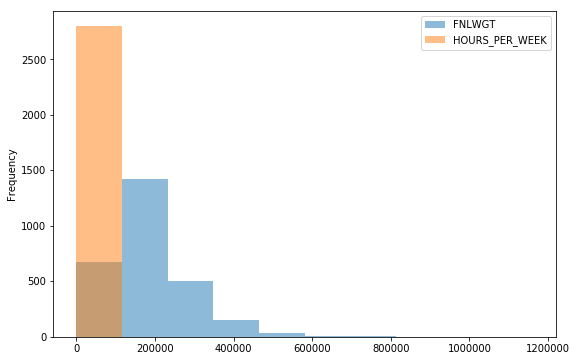

In [329]:
data.select_dtypes('int').plot.hist(alpha=0.5)

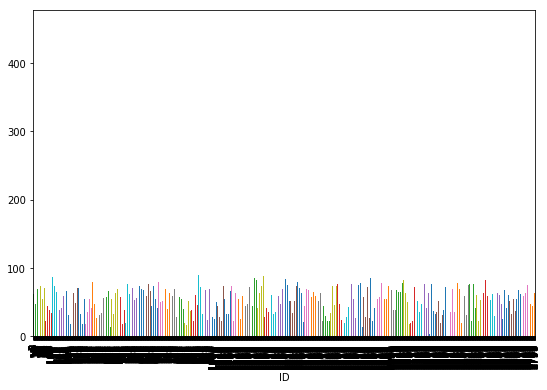

In [330]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
data['AGE'].plot.bar()


<Figure size 648x432 with 0 Axes>

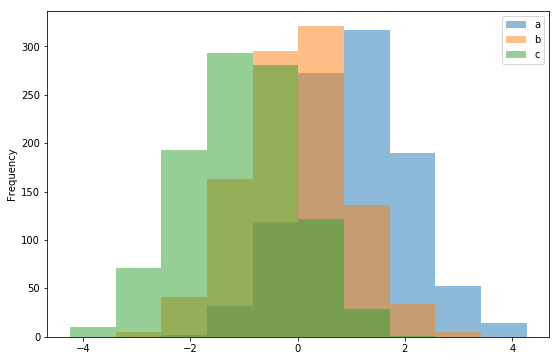

In [331]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

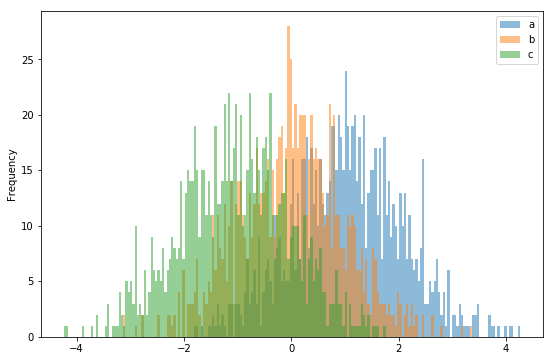

In [332]:
df4.plot.hist(alpha=0.5, bins=200)

In [333]:
plt.figure()
df['A'].head()

2000-01-01   -0.224251
2000-01-02    0.457582
2000-01-03   -0.201338
2000-01-04   -1.031391
2000-01-05    0.049684
Freq: D, Name: A, dtype: float64

<Figure size 648x432 with 0 Axes>

In [334]:
df['A'].diff().head()

2000-01-01         NaN
2000-01-02    0.681833
2000-01-03   -0.658921
2000-01-04   -0.830053
2000-01-05    1.081075
Freq: D, Name: A, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ed52978>,
      dtype=object)

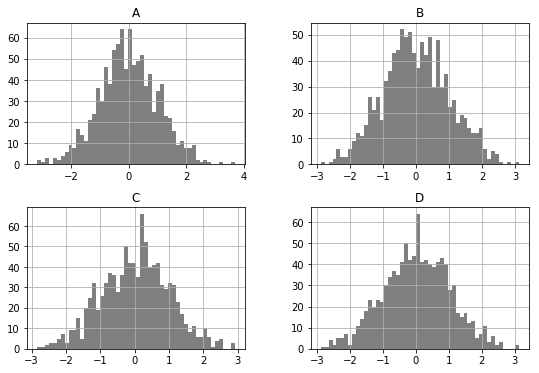

In [335]:
df.diff().hist(color='k', alpha=0.5, bins=50)

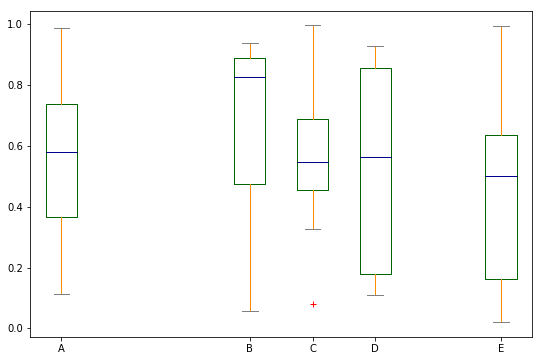

In [336]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

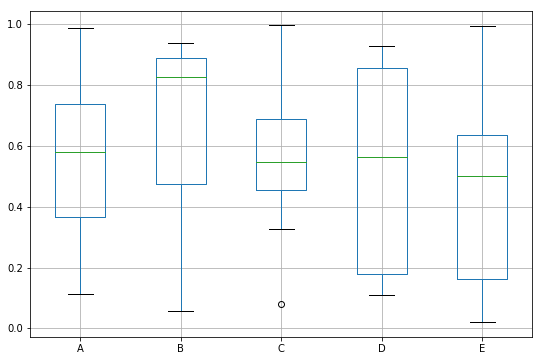

In [337]:
df.boxplot()

In [338]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

,Col1,Col2,X
0,0.248769,0.036506,A
1,0.887957,0.407190,A
2,0.002096,0.574088,A
3,0.285008,0.222813,A
4,0.368259,0.376302,A
5,0.894896,0.543697,B
6,0.288896,0.366367,B
7,0.049866,0.067807,B
8,0.745545,0.554090,B
9,0.200817,0.890348,B


<Figure size 648x432 with 0 Axes>

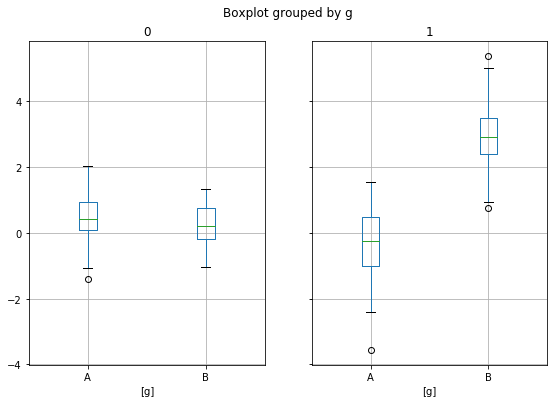

In [339]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [340]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

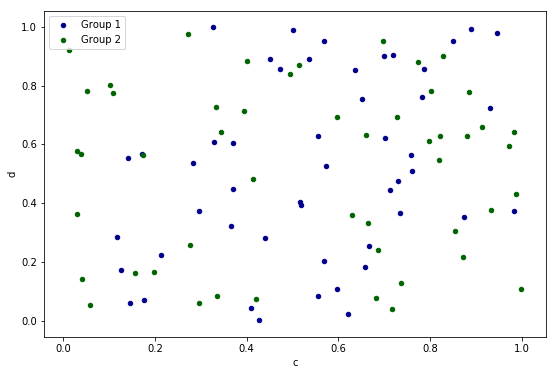

In [341]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

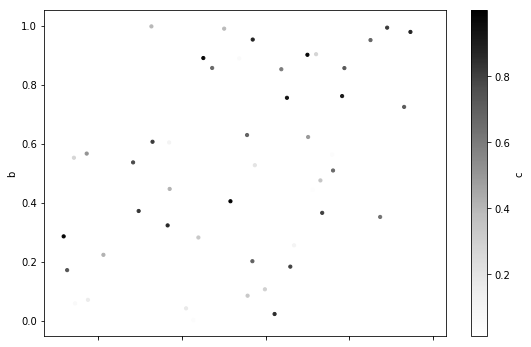

In [342]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html

# Manuálne podmienky vyhodnocovania

In [343]:
def calculate_recall(tp, fn):
     return tp / (tp + fn)

def calculate_precision(tp, fp):
    return tp / (tp + fp)

def calculate_accuracy(tp, tn, fp, fn):
    return (tn + tp)/(tn + fp + fn + tp)

In [344]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score

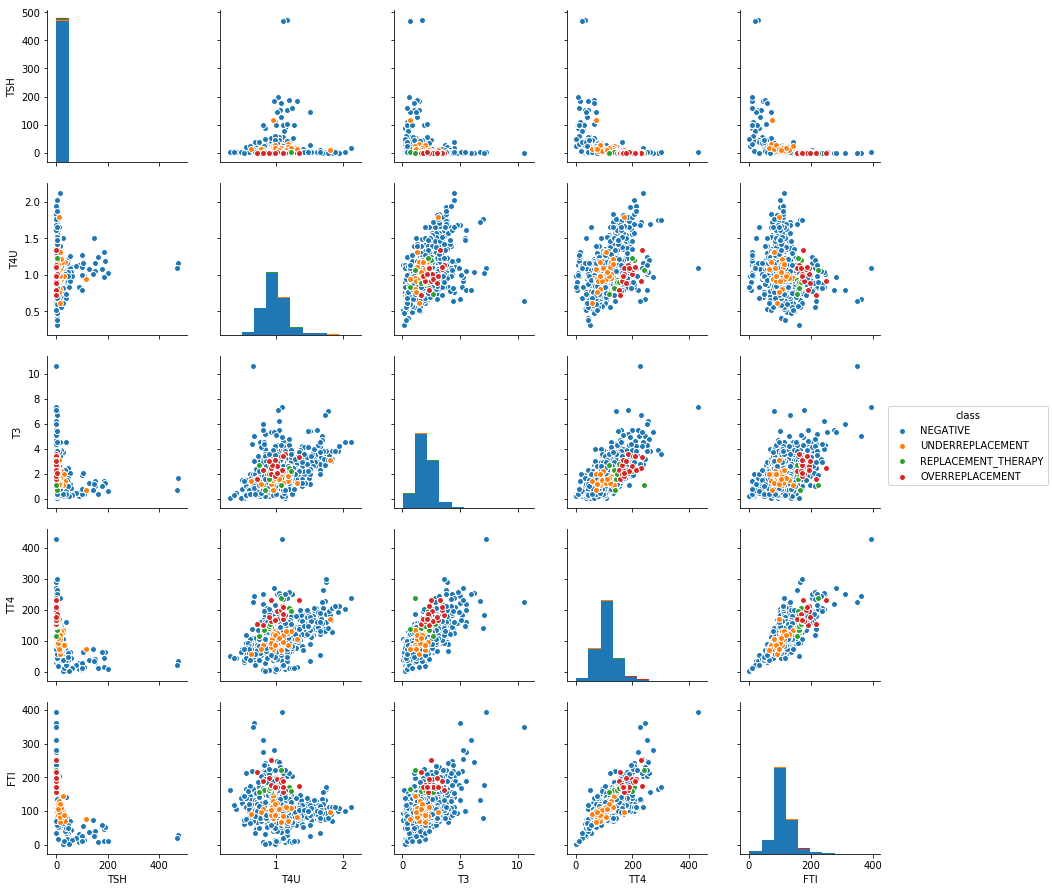

In [345]:
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()

seaborn.pairplot(dataFrame, dropna=True, hue='class')

Počet pacientov v jednotlivých triedach. 

In [346]:
data['CLASS'].value_counts()

NEGATIVE               2713
UNDERREPLACEMENT         35
REPLACEMENT_THERAPY      29
OVERREPLACEMENT          23
Name: CLASS, dtype: int64

## Atribúty FTI, TT4, T3, T4U

Väčšina pacientov, ktorí majú hodnoty atribútov **FTI, TT4, T3, T4U** také, ako sú špecifikované, tak sú zdravý.

In [347]:
df = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df['CLASS'].value_counts()

NEGATIVE            414
UNDERREPLACEMENT      6
Name: CLASS, dtype: int64

In [348]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Počet subjektov, ktoré nám naša podmienka našla: 420
Počet subjektov, ktoré sme sa snažili identifikovať: 2713
True positive: 414
False positive: 6
False negative: 2299
True negative: 81


Pokrytie (recall) daného pravidla

In [349]:
calculate_recall(tp, fn)

0.15259859933652783

Presnosť (precision) daného pravidla

In [350]:
calculate_precision(tp, fp)

0.9857142857142858

Accuracy daného pravidla

In [351]:
calculate_accuracy(tp, tn, fp, fn)

0.1767857142857143

Pri tejto podmienke sme sa snažili dovŕšiť čo najvyššiu presnosť vrátených dát, lebo určiť, že je pacient zdravý a pritom nie je, môže byť preňho kritické. 

### Rozpis jednotlivých atribútov (uvedieme len precision, pretože je prioritou)

In [352]:
rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

Počet subjektov, ktoré sme sa snažili identifikovať: 2713


### FTI

In [353]:
df = data[(data['FTI'] < 71)]
df['CLASS'].value_counts()

NEGATIVE            133
UNDERREPLACEMENT      3
Name: CLASS, dtype: int64

In [354]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

Počet subjektov, ktoré nám naša podmienka našla: 136
True positive: 133
False positive: 3


In [355]:
calculate_precision(tp, fp)

0.9779411764705882

### TT4

In [356]:
df = data[(data['TT4'] < 72)]
df['CLASS'].value_counts()

NEGATIVE            219
UNDERREPLACEMENT      4
Name: CLASS, dtype: int64

In [357]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

Počet subjektov, ktoré nám naša podmienka našla: 223
True positive: 219
False positive: 4


In [358]:
calculate_precision(tp, fp)

0.9820627802690582

### T3

In [359]:
df = data[(data['T3'] > 3.6)]
df['CLASS'].value_counts()

NEGATIVE    87
Name: CLASS, dtype: int64

In [360]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

Počet subjektov, ktoré nám naša podmienka našla: 87
True positive: 87
False positive: 0


In [361]:
calculate_precision(tp, fp)

1.0

### T4U

In [362]:
df = data[(data['T4U'] > 1.36)]
df['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [363]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

Počet subjektov, ktoré nám naša podmienka našla: 112
True positive: 111
False positive: 1


In [364]:
calculate_precision(tp, fp)

0.9910714285714286

## Kombinácie atribútov TSH, T3, FTI, T4U, TT4

In [365]:
df = data[(data['TSH'] < 0.2) & (data['T4U'] < 0.8)]
df['CLASS'].value_counts()

NEGATIVE               40
REPLACEMENT_THERAPY     3
OVERREPLACEMENT         1
Name: CLASS, dtype: int64

In [366]:
df = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [367]:
df = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df['CLASS'].value_counts()

NEGATIVE           98
OVERREPLACEMENT     1
Name: CLASS, dtype: int64

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali skoro všetkých pacientov, ktorí majú hodnotu **UNDERREPLACEMENT**.

In [368]:
df = data[(data['TSH'] > 5) & ((data['FTI'] > 63) & (data['FTI'] < 145))]
test = df['CLASS']
df['CLASS'].value_counts()

NEGATIVE            204
UNDERREPLACEMENT     33
Name: CLASS, dtype: int64

In [369]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'UNDERREPLACEMENT'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'UNDERREPLACEMENT'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Počet subjektov, ktoré nám naša podmienka našla: 237
Počet subjektov, ktoré sme sa snažili identifikovať: 35
True positive: 33
False positive: 204
False negative: 2
True negative: 2561


Pokrytie (recall) daného pravidla

In [370]:
calculate_recall(tp, fn)

0.9428571428571428

Presnosť (precision) daného pravidla

In [371]:
calculate_precision(tp, fp)

0.13924050632911392

Accuracy daného pravidla

In [372]:
calculate_accuracy(tp, tn, fp, fn)

0.9264285714285714

Z pozorovania vidíme, že dosiahnuté pokrytie je veľmi vysoké a naopak, presnosť je veľmi nízka. Pri našich dátach je prioritou dosiahnuť vyššie pokrytie. 

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali väčšinu pacientov, ktorí majú hodnotu **OVERREPLACEMENT** alebo **REPLACEMENT_THERAPY**. Týmto pravidlom sme chceli vyselektovať pacientov, ktorí nie sú zdraví, teda patria do jednej z tried **OVERREPLACEMENT, REPLACEMENT_THERAPY**.

In [373]:
df = data[(data['TSH'] < 1) & ((data['FTI'] > 155) & (data['FTI'] < 225))]
df['CLASS'].value_counts()

NEGATIVE               91
REPLACEMENT_THERAPY    25
OVERREPLACEMENT        21
Name: CLASS, dtype: int64

## Atribúty ON_ANTITHYROID_MEDICATION, I131_TREATMENT, LITHIUM, THYROID_SURGERY

Z nasledujúcej vzorky môžme povedať, že väčšina pacientov, ktorí boli na nejakej forme liečenia, alebo na operácii štítnej žlazy, tak sú zdravý.

In [374]:
df = data[
    (data['ON_ANTITHYROID_MEDICATION'] == True) | # nejaká liečba štítnej žlazy
    (data['I131_TREATMENT'] == True) |    # liečba rádiojódom
    (data['LITHIUM'] == True) |    # užíval lithium
    (data['THYROID_SURGERY'] == True)   # operácia štítnej žlazy
]
df['CLASS'].value_counts()

NEGATIVE               129
REPLACEMENT_THERAPY      3
UNDERREPLACEMENT         2
Name: CLASS, dtype: int64

In [375]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Počet subjektov, ktoré nám naša podmienka našla: 134
Počet subjektov, ktoré sme sa snažili identifikovať: 2713
True positive: 129
False positive: 5
False negative: 2584
True negative: 82


Pokrytie (recall) daného pravidla

In [376]:
calculate_recall(tp, fn)

0.0475488389237007

Presnosť (precision) daného pravidla

In [377]:
calculate_precision(tp, fp)

0.9626865671641791

Accuracy daného pravidla

In [378]:
calculate_accuracy(tp, tn, fp, fn)

0.07535714285714286

Európania v našom datasete sú zdravý. (nič divné, kedže európania tvoria len veľmi malú časť datasetu).

In [379]:
data['STATE'].value_counts()
df = data[(data['STATE'] == 'GERMANY') | 
          (data['STATE'] == 'POLAND') | 
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ITALY') |
          (data['STATE'] == 'GREECE') | 
          (data['STATE'] == 'SCOTLAND') 
         ]
df['CLASS'].value_counts()

NEGATIVE    44
Name: CLASS, dtype: int64

In [267]:
data

,AGE,SEX,ON_THYROXINE,QUERY_ON_THYROXINE,ON_ANTITHYROID_MEDICATION,SICK,PREGNANT,THYROID_SURGERY,I131_TREATMENT,QUERY_HYPOTHYROID,...,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,DATE_OF_BIRTH,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,,,,,,,,,,,,
0,72.0,FEMALE,True,False,False,False,False,False,False,False,...,0.0,0.0,40,1946-02-03,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK,REPLACEMENT_THERAPY
1,52.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,38,1965-08-27,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE,NEGATIVE
2,62.0,MALE,False,False,False,False,False,False,False,False,...,0.0,0.0,45,1955-04-15,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
3,23.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,20,1994-03-26,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
4,63.0,FEMALE,True,False,False,False,False,False,False,False,...,0.0,0.0,40,1955-01-21,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,REPLACEMENT_THERAPY
5,56.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,25,1961-12-10,OTHER_SERVICE,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
6,84.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,40,1934-03-03,ADM_CLERICAL,UNITED_STATES,WIDOWED,FEDERAL_GOV,WHITE,NEGATIVE
7,68.0,NaN,False,False,False,False,False,False,False,False,...,0.0,0.0,45,1949-07-21,ADM_CLERICAL,GERMANY,DIVORCED,PRIVATE,WHITE,NEGATIVE
8,19.0,MALE,False,False,False,False,False,False,False,False,...,0.0,0.0,20,1999-01-06,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,NEGATIVE
